# Merge 12 files
#### function name: merge_stu_log(files_path) , input: files path list, output: DataFrame of all data

In [1]:
import pandas as pd
import numpy as np

def merge_stu_log(files_path):
    # Initial DataFrame
    df = pd.DataFrame()
    log1 = pd.read_csv(files_path[0])
    initial_col_order = [col.lower() for col in list(log1.columns)]
    # in loop
    for file in files_path:
        #load csv file as pandas
        student_log = pd.read_csv(file)
        student_log.columns = [col.lower() for col in student_log]
        df = pd.concat([df, student_log])

    df = df[initial_col_order]
    return df

In [2]:
student_log_list = ["../dataset/anonymized_dataset_for_ADM2017/student_log_{}.csv".format(i) for i in range(1,13)]
student_log = merge_stu_log(student_log_list)


C:\Users\surface\Anaconda2\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py:2850: DtypeWarning: Columns (74,75) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


#  correlation

In [3]:
# all 1709 students' id
student_id_list = pd.unique(student_log['itest_id'])
# useful features
coeffecient_name_list = ['itest_id','aveknow','avecarelessness','avecorrect','numactions','averesbored','averesengcon',
                         'averesconf','averesfrust','averesofftask','averesgaming']
student_log_uni = student_log[coeffecient_name_list]

# delete same lines
student_log_uni = student_log_uni.drop_duplicates().copy()
student_log_uni.reset_index(drop=True, inplace=True)
student_log_uni.head()

,itest_id,aveknow,avecarelessness,avecorrect,numactions,averesbored,averesengcon,averesconf,averesfrust,averesofftask,averesgaming
0,8,0.352416,0.183276,0.483902,1056,0.208389,0.679126,0.115905,0.112408,0.156503,0.196561
1,35,0.255164,0.158848,0.379658,993,0.222796,0.650079,0.069987,0.164347,0.153147,0.236800
2,39,0.281693,0.152227,0.454545,418,0.274700,0.628075,0.116390,0.143827,0.221926,0.019817
3,64,0.157938,0.098357,0.334038,1419,0.198394,0.670062,0.085895,0.132328,0.115773,0.303426
4,77,0.191948,0.094195,0.413249,317,0.261455,0.638636,0.063971,0.129858,0.234331,0.045096


In [4]:
def all_lower(L1):
    return [s.lower() for s in L1]

training_dataset = pd.read_csv("../dataset/anonymized_dataset_for_ADM2017/training_label.csv")
training_dataset.columns = all_lower(training_dataset.columns.tolist())
training_dataset = training_dataset[all_lower(['ITEST_id','MCAS','isSTEM'])]
# training_dataset
training_set = student_log_uni.merge(training_dataset, on='itest_id', how="right")
training_set = training_set[training_set['mcas']!=-999]
training_set.reset_index(drop=True, inplace=True)
training_set.head()

,itest_id,aveknow,avecarelessness,avecorrect,numactions,averesbored,averesengcon,averesconf,averesfrust,averesofftask,averesgaming,mcas,isstem
0,35,0.255164,0.158848,0.379658,993,0.222796,0.650079,0.069987,0.164347,0.153147,0.236800,34,0
1,77,0.191948,0.094195,0.413249,317,0.261455,0.638636,0.063971,0.129858,0.234331,0.045096,39,0
2,126,0.250838,0.111159,0.500000,406,0.273188,0.646944,0.104602,0.131632,0.230005,0.040233,30,0
3,205,0.229988,0.126401,0.445407,577,0.242691,0.658863,0.112356,0.132230,0.185330,0.077827,29,0
4,283,0.146352,0.093224,0.309661,1211,0.211405,0.655711,0.079308,0.102920,0.126860,0.245489,11,0


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
def correlation(dataframe):
    corr = dataframe.corr()  
    sns.set(style="white")
    sns.heatmap(corr, annot=True)
    plt.show()
def histogram(feature,name):
    feature1=feature[name]
    plt.hist(feature1)
    plt.show()

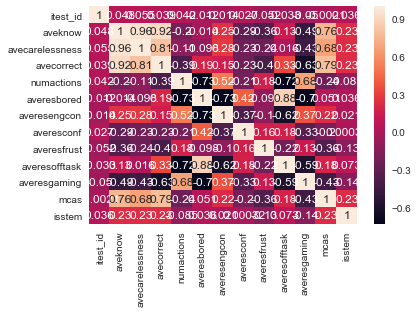

In [6]:
correlation(training_set)

feature name: aveknow


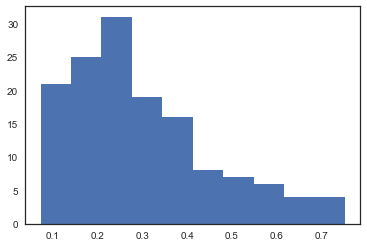

feature name: avecarelessness


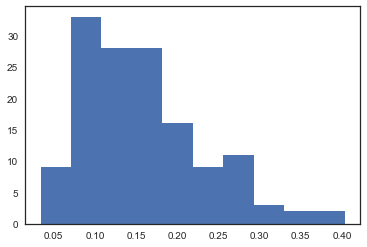

feature name: avecorrect


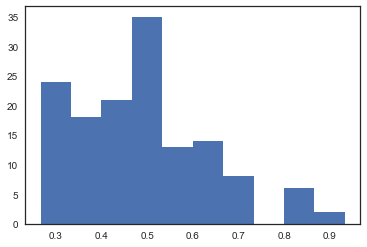

feature name: numactions


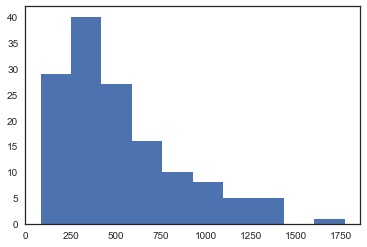

feature name: averesbored


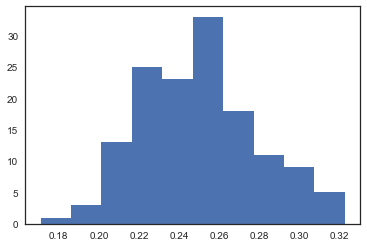

feature name: averesengcon


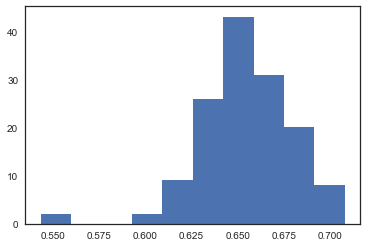

feature name: averesconf


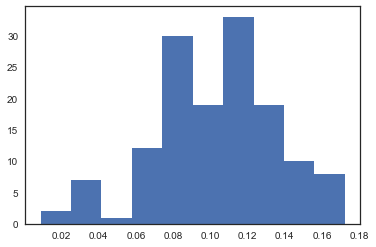

feature name: averesfrust


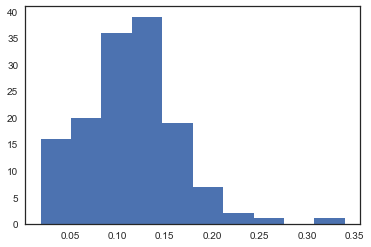

feature name: averesofftask


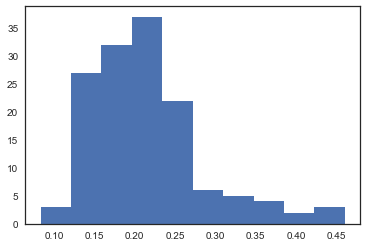

feature name: averesgaming


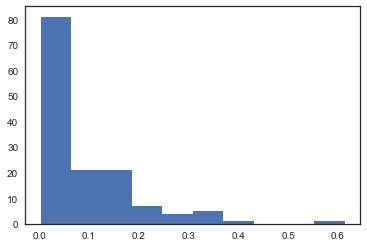

feature name: mcas


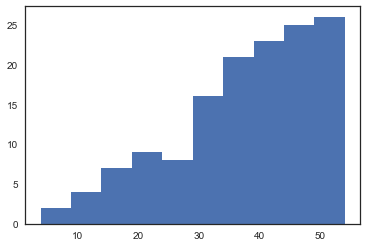

In [8]:
training_name = training_set.columns.tolist()
isSTEM = training_set[training_set['isstem']==1]
for name in training_name[1:-1]:
    print("feature name: %s" % name)
    histogram(isSTEM,name)

### preprocess : standard scaler

In [27]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
select_columns = ['aveknow','avecarelessness','avecorrect','numactions','averesbored','averesengcon',
                         'averesconf','averesfrust','averesofftask','averesgaming','mcas']
t=training_set[select_columns]
scaler.fit(t)
t = scaler.transform(t)
dataframe=pd.DataFrame(t,columns=select_columns)
dataframe['itest_id'] = training_set['itest_id']
dataframe['isstem']=training_set['isstem']

#  feature selection

### Logistic regression

In [174]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn import metrics
import math


def logistic(df,k,l1):
    X=df.loc[:,select_columns]
    X1=X.values   
    y=df['isstem']
    y1=y.values  
    kf=KFold(k,shuffle=True)
    accurate=[]
    for train_index, test_index in kf.split(X1):
        X_train,X_test=X1[train_index],X1[test_index]
        y_train,y_test=y1[train_index],y1[test_index]
        log=LogisticRegression(C= l1, penalty="l1", dual=False)
        log.fit(X_train,y_train)
        pred = log.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)
        AUC = metrics.auc(fpr, tpr)
        RMES = math.sqrt(metrics.mean_squared_error(y_test, pred))
        accurate.append(AUC)
    mean_acc=np.mean(accurate)
    return mean_acc , RMES ,log



###  l1 regularlization

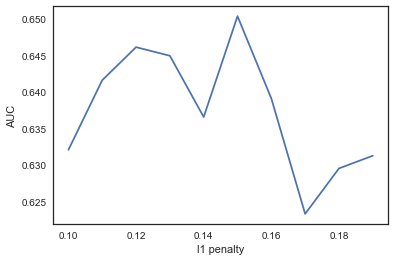

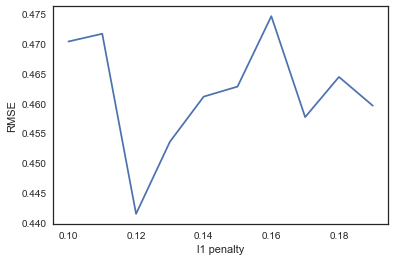

AUC:0.636128
RMSE:0.463555
[[ 0.          0.28284294  0.          0.          0.         -0.02684698
   0.08584263  0.          0.02792398 -0.02892725  0.10387859]]


In [175]:
from sklearn.feature_selection import SelectFromModel

l1_reg_c = np.arange(0.1, 0.2, 1e-2)
K_Forder = 4
df=dataframe
acc_list = []
l1_list =[]
RMSE_list = []
for l1_c in l1_reg_c:
    acc,RMSE, model = logistic(df,K_Forder,l1_c)
    acc_list.append(acc)
    l1_list.append(l1_c)
    RMSE_list.append(RMSE)
    

plt.xlabel("l1 penalty")
plt.ylabel("AUC")
plt.plot(l1_reg_c,acc_list)

plt.show()

plt.xlabel("l1 penalty")
plt.ylabel("RMSE")
plt.plot(l1_reg_c,RMSE_list)
plt.show()


l1_c = l1_list[acc_list.index(max(acc_list))]
acc, RMSE, model = logistic(df,K_Forder,l1_c)
print("AUC:%f" % acc)
print("RMSE:%f" % RMSE)
print(model.coef_)

In [179]:
from sklearn.ensemble import RandomForestClassifier

def RandomFC(df,c,estimators,depth):
    X=df.loc[:,select_columns]
    X1=X.values
    y=df['isstem']
    y1=y.values
    kf=KFold(c,shuffle=True)
    accurate=[]
    for train_index, test_index in kf.split(X1):
        X_train,X_test=X1[train_index],X1[test_index]
        y_train,y_test=y1[train_index],y1[test_index]
        RFC=RandomForestClassifier(n_estimators=estimators,oob_score=True,max_depth=depth,max_features='auto') 
        RFC.fit(X_train,y_train)
        pred = RFC.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)
        AUC = metrics.auc(fpr, tpr)
        RMSE = math.sqrt(metrics.mean_squared_error(y_test, pred))
        accurate.append(AUC)
    mean_acc=np.mean(accurate)
    return mean_acc,RMSE,RFC 


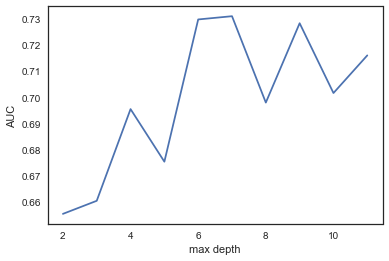

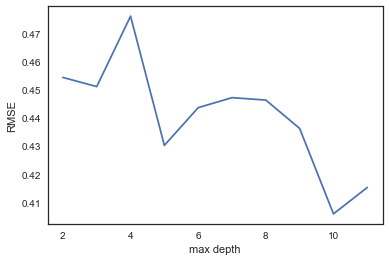

In [180]:
df=dataframe
depth_list = range(2,12)
acc_RFC_list=[]
RMSE_list = []
for depth in depth_list:
    acc_rfc,RMSE,RFC =RandomFC(df,4,63,depth)
    acc_RFC_list.append(acc_rfc)
    RMSE_list.append(RMSE)

plt.xlabel("max depth")
plt.ylabel("AUC")
plt.plot(depth_list,acc_RFC_list)
plt.show()

plt.xlabel("max depth")
plt.ylabel("RMSE")
plt.plot(depth_list,RMSE_list)
plt.show()



In [194]:
depth = 7
acc_rfc, RMSE, RFC = RandomFC(df,4,63,depth)
print("AUC:%f" % acc_rfc)
print("RMSE:%f" % RMSE)
print(RFC.feature_importances_)

AUC:0.738047
RMSE:0.424801
[[ 0.          0.28284294  0.          0.          0.         -0.02684698
   0.08584263  0.          0.02792398 -0.02892725  0.10387859]]
[ 0.10075789  0.10479221  0.07709898  0.07225606  0.06707567  0.07938181
  0.09404939  0.09529947  0.07671076  0.13490611  0.09767165]


## regularization when model is over fitting